In [18]:
# import sys
# !{sys.executable} -m pip install ing_theme_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# import qbstyles
# from ing_theme_matplotlib import mpl_style
import glacierml as gl
from tqdm import tqdm

# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [27]:
# raw_dataset = pd.read_csv('/data/fast0/datasets/glathida-3.1.0/data/T.csv')
T = pd.read_csv('/home/sa42/data/glac/T_models/T.csv')
T = T.drop([
    'GlaThiDa_ID',
    'POLITICAL_UNIT',
    'GLACIER_NAME',
    'GLACIER_DB',
    'GLACIER_ID',
    'SURVEY_DATE',
    'ELEVATION_DATE',
    'MEAN_THICKNESS',
    'MEAN_THICKNESS_UNCERTAINTY',
#     'MAXIMUM_THICKNESS',
    'MAX_THICKNESS_UNCERTAINTY',
    'SURVEY_METHOD',
    'SURVEY_METHOD_DETAILS',
    'NUMBER_OF_SURVEY_POINTS',
    'NUMBER_OF_SURVEY_PROFILES',
    'TOTAL_LENGTH_OF_SURVEY_PROFILES',
    'INTERPOLATION_METHOD',
    'INVESTIGATOR',
    'SPONSORING_AGENCY',
    'REFERENCES',
    'DATA_FLAG',
    'REMARKS'
],axis=1)
T = T.dropna()
T

,LAT,LON,AREA,MEAN_SLOPE,MAXIMUM_THICKNESS
32,48.750000,-121.830000,2.900,0.0,107.0
33,58.380000,-134.360000,11.700,0.0,200.0
44,38.767000,72.283000,824.000,0.0,900.0
47,45.236450,80.781660,3.200,0.0,116.0
48,45.235130,80.808350,3.400,0.0,139.0
...,...,...,...,...,...
616,61.730000,5.660000,3.280,9.0,163.0
620,78.245480,16.064380,2.100,13.0,106.0
628,43.043653,77.080587,2.610,20.0,103.0
632,77.971400,14.069100,6.737,6.0,191.0


In [28]:
# TTT = pd.read_csv('/home/sa42/data/glac/T_models/TTT.csv')
# TTT = TTT.drop([
# #     'GlaThiDa_ID',
#     'POLITICAL_UNIT',
#     'GLACIER_NAME',
#     'SURVEY_DATE',
#     'PROFILE_ID',
#     'POINT_ID',
# #     'POINT_LAT',
# #     'POINT_LON',
# #     'ELEVATION',
# #     'THICKNESS',
#     'THICKNESS_UNCERTAINTY',
#     'DATA_FLAG',
#     'REMARKS'
# ],axis=1)
# TTT

In [29]:
# df = pd.merge(TTT,T, how='inner',on='GlaThiDa_ID')
# df = df.drop([
#     'GlaThiDa_ID'
# ],axis=1)
# df

In [30]:
# TT = pd.read_csv('/home/sa42/data/glac/T_models/TT.csv')
# TT = TT.drop([
# #     'GlaThiDa_ID',
#     'POLITICAL_UNIT',
#     'GLACIER_NAME',
#     'SURVEY_DATE',
# #     'LOWER_BOUND',
# #     'UPPER_BOUND',
# #     'AREA',
# #     'MEAN_SLOPE',
# #     'MEAN_THICKNESS',
#     'MEAN_THICKNESS_UNCERTAINTY',
#     'MAXIMUM_THICKNESS',
#     'MAX_THICKNESS_UNCERTAINTY',
#     'DATA_FLAG',
#     'REMARKS'
# ],axis=1)
# TT = TT.dropna()
# TT

In [31]:
# # raw_dataset = pd.read_csv('/data/fast0/datasets/glathida-3.1.0/data/T.csv')
# T = pd.read_csv('/home/sa42/data/glac/T_models/T.csv')
# T.rename(columns = {
#     'LAT':'T_LAT_CENT',
#     'LON':'T_LON_CENT',
#     'AREA':'T_AREA',
#     'MEAN_SLOPE':'T_MEAN_SLOPE',
# #     'MEAN_THICKNESS':'T_MEAN_THICKNESS',
# #     'MAXIMUM_THICKNESS':'T_MAXIMUM_THICKNESS' 
# },inplace=True)

# TTT = pd.read_csv('/home/sa42/data/glac/T_models/TTT.csv')
# TTT.rename(columns = {
#     'ELEVATION':'TTT_POINT_ELEVATION',
#     'THICKNESS':'TTT_POINT_THICKNESS',
#     'POINT_LAT':'TTT_POINT_LAT',
#     'POINT_LON':'TTT_POINT_LON'
# },inplace=True)
# df1 = pd.merge(T,TT, how = 'inner', on='GlaThiDa_ID')
# # glathida = pd.merge(T,TTT, how = 'inner', on='GlaThiDa_ID')
# # glathida = glathida[[
# # #     'GlaThiDa_ID',
# # #     'GLACIER_DB',
# # #     'GLACIER_ID',
# #     'T_LAT_CENT',
# #     'T_LON_CENT',
# #     'T_AREA',
# #     'T_MEAN_SLOPE',
# #     'T_MEAN_THICKNESS',
# #     'T_MAXIMUM_THICKNESS',
# #     'TT_LOWER_BOUND',
# #     'TT_UPPER_BOUND',
# #     'TT_AREA',
# #     'TT_MEAN_SLOPE',
# #     'TT_MEAN_THICKNESS',
# #     'TT_MAXIMUM_THICKNESS',
# #     'TTT_POINT_LAT',
# #     'TTT_POINT_LON',
# #     'TTT_POINT_ELEVATION',
# #     'TTT_POINT_THICKNESS',   
# # ]]
# # glathida = glathida.dropna()

### separate out features - what will be trained to predict desired attribute

In [34]:
train_dataset = T.sample(frac=0.8, random_state=0)
test_dataset = T.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop('MAXIMUM_THICKNESS')
test_labels = test_features.pop('MAXIMUM_THICKNESS')

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,48.773965,18.881859
LON,18.892849,50.790507
AREA,19.945168,113.908179
MEAN_SLOPE,16.288462,9.049616


# Step 2: Setup the Model

### Establish normalization layers

In [35]:
normalizer = {}
variable_list = list(train_features)
for variable_name in tqdm(variable_list):

    normalizer[variable_name] = gl.preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = gl.preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


In [36]:
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [37]:
%%time
for variable_name in tqdm(variable_list):

    linear_model[variable_name] = gl.build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

100%|██████████| 4/4 [00:11<00:00,  2.89s/it]

CPU times: user 14.6 s, sys: 5.84 s, total: 20.5 s
Wall time: 11.6 s


In [38]:
# fig,ax=plt.subplots(2,6,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
# #     mpl_style("dark")
#     ax = plt.subplot(4,4,i+1)
#     plt.subplot(4,4,i+1)
#     gl.plot_loss(linear_history[variable_name])
#     ax.set_title(variable_name)
# #     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

# Linear regression with multiple inputs

In [39]:
linear_model = gl.build_linear_model(normalizer['ALL'])

linear_history['MULTI'] = linear_model.fit(
train_features, train_labels,        
   epochs=100,
   verbose=0,
   validation_split = 0.2)

linear_results['MULTI'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

In [40]:
# gl.plot_loss(history_full)
# # plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [41]:
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [42]:
for variable_name in tqdm(variable_list):

    dnn_model[variable_name] = gl.build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

100%|██████████| 4/4 [00:12<00:00,  3.08s/it]


In [ ]:
# fig,ax=plt.subplots(4,4,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
#     plt.subplot(4,4,i+1)
#     xmax = np.max(train_features[variable_name])
#     xmin = np.min(train_features[variable_name])
#     x = tf.linspace(xmin, xmax, 101)
#     y = dnn_model[variable_name].predict(x)
#     plot_single_model_variable(x,y,variable_name)

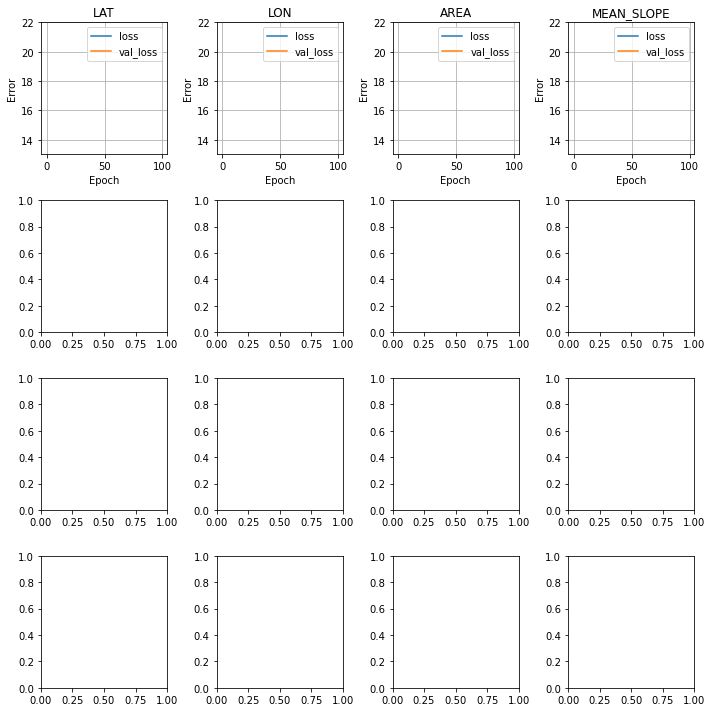

In [43]:
fig,ax=plt.subplots(4,4,figsize=(10,10))
fig.patch.set_facecolor('w')
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(4,4,i+1)
    gl.plot_loss(dnn_history[variable_name])
    ax.set_ylim([13,22])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()

# Full model

In [44]:
dnn_full_model = gl.build_dnn_model(normalizer['ALL'])

dnn_history['MULTI'] = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

dnn_results['MULTI'] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

<function glacierml.plot_loss(history)>

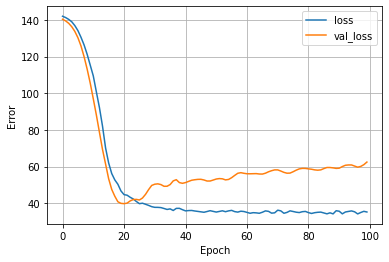

In [45]:
gl.plot_loss(dnn_history['MULTI'])
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 200.0)

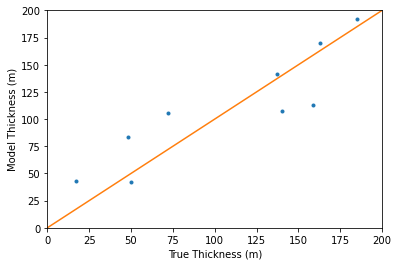

In [46]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,200),(0,200),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,200))
plt.ylim((0,200))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")

In [52]:
print(y)

[[293.01282 ]
 [212.95413 ]
 [ 42.83351 ]
 [ 42.181602]
 [ 83.26924 ]
 [141.4837  ]
 [250.61526 ]
 [191.87817 ]
 [107.84884 ]
 [112.644516]
 [105.52382 ]
 [169.76291 ]
 [170.25018 ]]


# Collect Results

In [47]:
dfs = pd.DataFrame()
for variable_name in list(dnn_history):    
    df1 = pd.DataFrame(dnn_history[variable_name].history)
    df1 = df1.loc[[df1.last_valid_index()]]
    df1['Architecture'] = 'DNN'
    df1.insert(0, 'Variable', [variable_name])

    df2 = pd.DataFrame(linear_history[variable_name].history)
    df2 = df2.loc[[df2.last_valid_index()]]
    df2['Architecture'] = 'Linear'
    df2.insert(0, 'Variable', [variable_name])
    
    df = pd.concat([df1,df2])
    dfs = dfs.append(df)
    
df = dfs[[
    'Architecture',
    'Variable',
    'loss',
    'val_loss'
]]
df.rename(columns = {
    'loss':'Training Loss',
    'val_loss':'Test loss'
},inplace=True)
df = df.sort_values(by=['Architecture','Variable'], ascending=[False,False])
print(df.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
Architecture &   Variable &  Training Loss &  Test loss \\
\midrule
      Linear &      MULTI &     119.897743 & 132.504547 \\
      Linear & MEAN\_SLOPE &     122.855751 & 121.869743 \\
      Linear &        LON &     120.226585 & 130.520996 \\
      Linear &        LAT &     122.802750 & 122.064819 \\
      Linear &       AREA &     122.555870 & 122.444656 \\
         DNN &      MULTI &      35.203091 &  62.443577 \\
         DNN & MEAN\_SLOPE &      56.545399 &  65.120369 \\
         DNN &        LON &      81.203842 &  87.585754 \\
         DNN &        LAT &      74.708160 &  66.349419 \\
         DNN &       AREA &      62.929432 &  76.250198 \\
\bottomrule
\end{tabular}

